In [1]:
from scipy.io import loadmat
x = loadmat('svhn_data/train_32x32.mat')
#lon = x['lon']
#lat = x['lat']
# one-liner to read a single variable
#lon = loadmat('test.mat')['lon']

In [29]:
i = 0
for key,value in x.items():
    i+=1
    if i == 4:
        print(value[0][0][0])


[ 33  84  19 ...  92 190 216]


In [35]:
x['X'][:,:,:,1].shape

(32, 32, 3)

In [37]:
from matplotlib import pyplot as plt

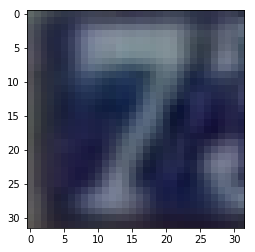

In [49]:
plt.imshow(x['X'][:,:,:,38956])